# MNE workshop example

## Data import and preprocessing

In [69]:
import mne
from mne.preprocessing import ICA

import os

import numpy as np

os.chdir('F:\\TBS_KB\\')

MNE provides a broad range of montage files, supporting the 10-05, 10-20 and EGI's geodesic elctrode positioning system as well as many different manufacturers' caps (EGI, biosemi, easycap).

For this example, I want to show that the MNE info structure can be easily adapted with custom montages.

In [70]:
fname = 'TMSKB0006.vhdr'
kind = 'standard_1020'
eog = ['VEOG', 'LHZ', 'RHZ']

When reading event codes they are stripped to their integer parts (S1 -> 1).

In [242]:
montage = mne.channels.read_montage(kind=kind)
raw = mne.io.read_raw_brainvision(fname, preload=True, montage=montage, eog=eog)

Extracting parameters from TMSKB0006.vhdr...
Setting channel info structure...
Reading 0 ... 2088979  =      0.000 ...  2088.979 secs...


<ipython-input-242-0674363274e9>:2: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_brainvision(fname, preload=True, montage=montage, eog=eog)


Used Annotations descriptions: ['Stimulus/S 20', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S  5', 'Stimulus/S  8', 'Stimulus/S  9', 'Stimulus/S  4', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S 21']


Let's look at the raw data.

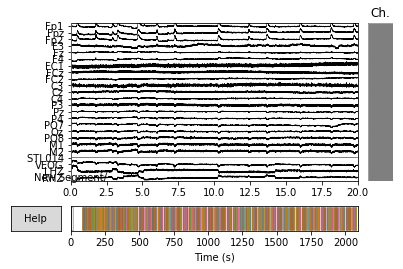

In [72]:
raw.plot(duration=20, n_channels=24, scalings=dict(eeg=100e-6));

Before starting to preprocess the data, pick the channels to be filtered and refreferenced. Apply a bandpass filter (0.1, 30Hz) and rereference to the mean of the two mastoid positions.

In [243]:
picks = mne.pick_types(raw.info, eeg=True)

raw.filter(1, 20) 
raw.set_eeg_reference(ref_channels=['M1','M2'], projection=False)

Setting up band-pass filter from 1 - 20 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 3301 samples (3.301 sec) selected
Applying a custom EEG reference.


<RawBrainVision  |  TMSKB0006.eeg, n_channels x n_times : 24 x 2088980 (2089.0 sec), ~382.6 MB, data loaded>

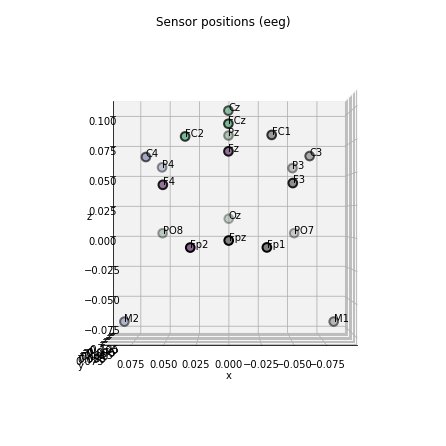

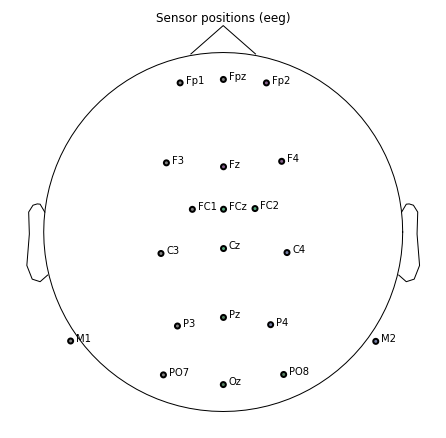

In [74]:
raw.copy().plot_sensors(kind='3d', ch_groups='position', show_names=True);
raw.copy().plot_sensors(kind='topomap', ch_groups='position', show_names=True);

Next, put together all arguments necessary for starting an Independent Component Analysis (ICA). For the purpose of this example, let's keep the parameters for reducing the amount of data samples (decim) and for detecting data segments which should be excluded (reject) at None.

In [213]:
n_components = 10  
method = 'extended-infomax'
decim = None
reject = None

ica = ICA(n_components=n_components, method=method)

In [244]:
ica.fit(raw, decim=decim, reject=reject)

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selection by number: 10 components
Computing Extended Infomax ICA
Fitting ICA took 122.5s.


<ICA  |  raw data decomposition, fit (extended-infomax): 2088980 samples, 10 components, channels used: "eeg">

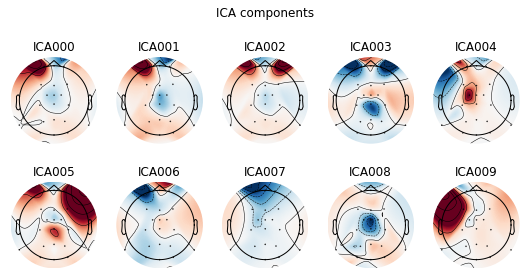

In [77]:
ica.plot_components(outlines="skirt");

For selecting artifact components we check the topographies, frequency spectra and temporal distribution of components. That takes a little bit of practice, but most artifact components are quite distinct and easy to spot.

    Using multitaper spectrum estimation with 7 DPSS windows


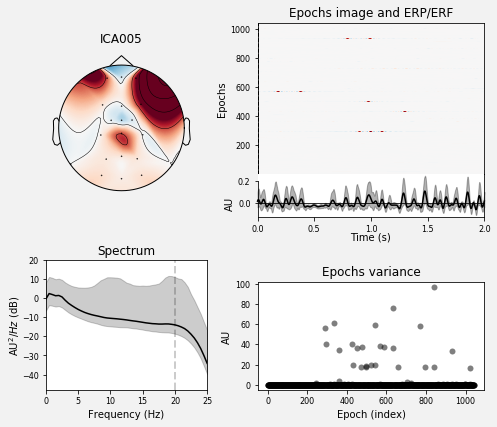

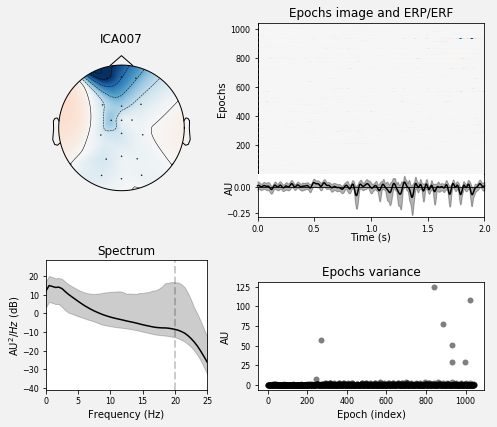

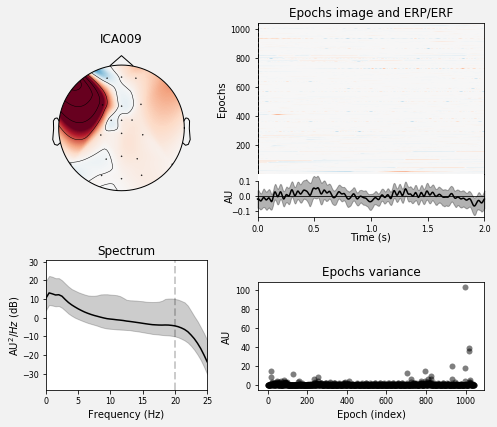

[<Figure size 504x432 with 5 Axes>,
 <Figure size 504x432 with 5 Axes>,
 <Figure size 504x432 with 5 Axes>]

In [192]:
ica.plot_properties(raw, [5,7,9])

But sometimes you want a more objective way of rating artifact components. So let's look at what automatic algorithms (based on channel activity) classify as artifacts.

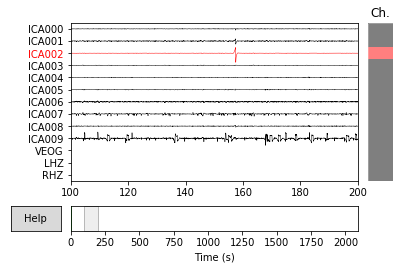

In [252]:
from scipy.stats import pearsonr

corr = lambda x, y: np.array([pearsonr(a, y.ravel()) for a in x])[:, 0]

# The find_sources method returns and array of correlation
# scores for each ICA source.
eog_scores = ica.score_sources(raw, target='VEOG', score_func=corr)

# Get the component index of the maximum correlation with the ECG
eog_source_idx = np.abs(eog_scores).argmax()

# Mark the sources with the strongest correlations
ica.plot_sources(raw, exclude=[eog_source_idx], picks=[0,1,2,3,4,5,6,7,8,9], start=100, stop=200);

In [245]:
# Blinks
bad_idxV, scoresV = ica.find_bads_eog(raw, 'VEOG', threshold=2)
# Saccades
bad_idxH, scoresH = ica.find_bads_eog(raw, 'LHZ', threshold=2)

Using channel VEOG as EOG channel
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected
... filtering target
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected
Using channel LHZ as EOG channel
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected
... filtering target
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (16.384 sec) selected


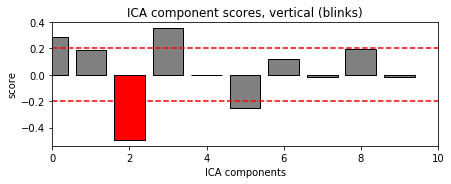

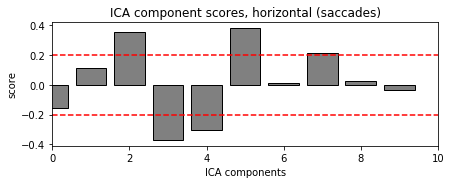

In [246]:
ica.plot_scores(scoresV, title='ICA component scores, vertical (blinks)',
                exclude=bad_idxV, # Mark the identified eog artifact components red
                show=True, 
                axhline=[0.2, -0.2]); # Plot a horizontal line to mark a score threshold
ica.plot_scores(scoresH, title='ICA component scores, horizontal (saccades)',
                exclude=bad_idxH,
                show=True, 
                axhline=[0.2, -0.2]);

Here are some safe picks, which were consistently marked as possible artifacts by algorithms and by conventional visual inspection.

In [194]:
ica.exclude = [0,2,3,5,7,9]

Let's compare raw and corrected data ...

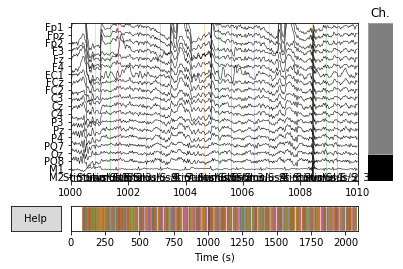

In [195]:
raw.plot(start=1000, duration=10);

Transforming to ICA space (10 components)
Zeroing out 6 ICA components


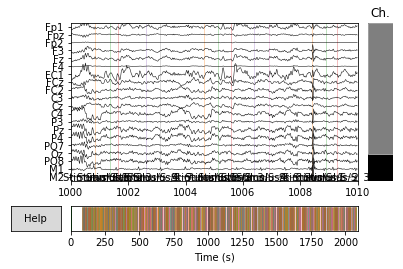

In [203]:
ica.apply(raw, exclude=ica.exclude).plot(start=1000, duration=10);

## Epoching

Moving on to finding the EEG segments we want to analyze. Here, we first have to import the important information from the event file.

In [204]:
event_id = {'reward_right': 7, 'reward_left': 9, 'no_reward_right': 6, 'no_reward_left': 8}
events = mne.find_events(raw, shortest_event=0, initial_event=True)

2279 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 20 21]


events is simply an array (time in samples, zero, trigger);

In [148]:
events[:10]

array([[82578,     0,    20],
       [82604,     0,     1],
       [83999,     0,     2],
       [85249,     0,     3],
       [85355,     0,    10],
       [85748,     0,    11],
       [87256,     0,     1],
       [87749,     0,     2],
       [88518,     0,     3],
       [89016,     0,     5]], dtype=int64)

For a sanity check, let's look at the distribution of the first 100 events over time.

<ipython-input-149-2100c3df6c04>:1: RuntimeWarning: event 1 missing from event_id will be ignored
  mne.viz.plot_events(events[:1000], sfreq=raw.info['sfreq'], event_id=event_id, show=True);
<ipython-input-149-2100c3df6c04>:1: RuntimeWarning: event 2 missing from event_id will be ignored
  mne.viz.plot_events(events[:1000], sfreq=raw.info['sfreq'], event_id=event_id, show=True);
<ipython-input-149-2100c3df6c04>:1: RuntimeWarning: event 3 missing from event_id will be ignored
  mne.viz.plot_events(events[:1000], sfreq=raw.info['sfreq'], event_id=event_id, show=True);
<ipython-input-149-2100c3df6c04>:1: RuntimeWarning: event 4 missing from event_id will be ignored
  mne.viz.plot_events(events[:1000], sfreq=raw.info['sfreq'], event_id=event_id, show=True);
<ipython-input-149-2100c3df6c04>:1: RuntimeWarning: event 5 missing from event_id will be ignored
  mne.viz.plot_events(events[:1000], sfreq=raw.info['sfreq'], event_id=event_id, show=True);
<ipython-input-149-2100c3df6c04>:1: RuntimeWa

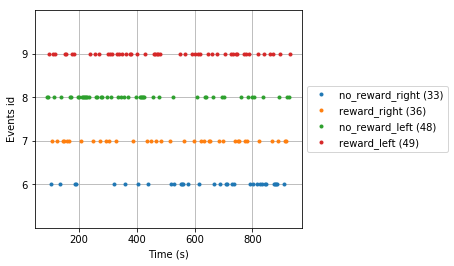

In [149]:
mne.viz.plot_events(events[:1000], sfreq=raw.info['sfreq'], event_id=event_id, show=True);

In [150]:
tmin, tmax = -0.2, 0.8
baseline = -0.2, -0.1
epochs_evoked = mne.Epochs(raw, events=events, event_id=event_id, picks=picks,
                           tmin=tmin, tmax=tmax, baseline=baseline)
epochs_tfr = mne.Epochs(raw, events=events, event_id=event_id, picks=picks,
                        tmin=-0.5, tmax=1.5, baseline=None)

404 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
404 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


Now we can plot some data.

Loading data for 201 events and 1001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


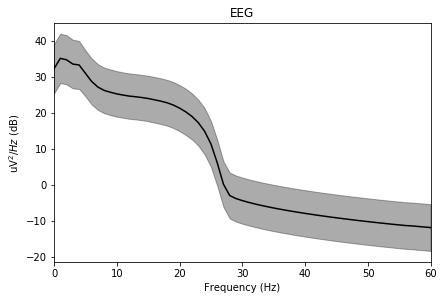

Loading data for 203 events and 1001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


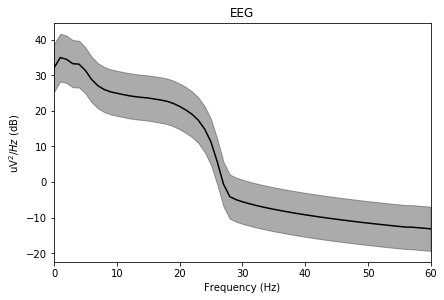

In [151]:
epochs_evoked['reward_right', 'reward_left'].plot_psd(fmin=0, fmax=60);
epochs_evoked['no_reward_right', 'no_reward_left'].plot_psd(fmin=0, fmax=60);

Loading data for 201 events and 1001 original time points ...
0 bad epochs dropped


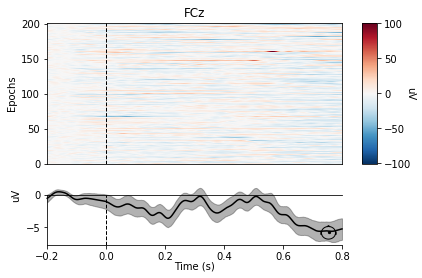

Loading data for 203 events and 1001 original time points ...
0 bad epochs dropped


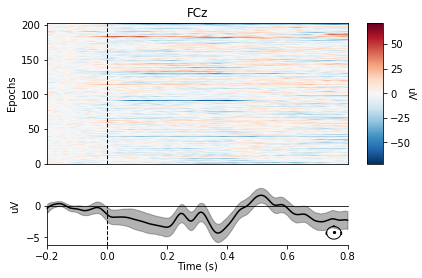

In [152]:
epochs_evoked['reward_right', 'reward_left'].plot_image(picks=[7]);
epochs_evoked['no_reward_right', 'no_reward_left'].plot_image(picks=[7]);

In [155]:
reward = epochs_evoked['reward_left','reward_right'].average()
noreward = epochs_evoked['no_reward_left','no_reward_right'].average()

difference_feedback = mne.combine_evoked((reward,noreward),[1,-1])

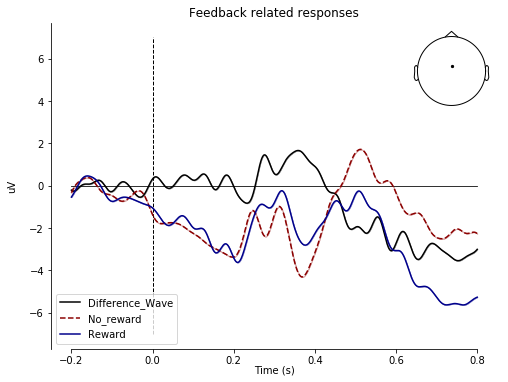

In [156]:
colors = dict(Reward = 'darkblue', No_reward = 'darkred', 
              Difference_Wave = 'black')
maze_dict = {'Reward': reward, 'No_reward': noreward, 
               'Difference_Wave': difference_feedback}

linestyles = dict(Reward = '-', No_reward = '--', 
                  Difference_Wave = '-')

ylim = dict(eeg=[-7,7])

mne.viz.plot_compare_evokeds(maze_dict, picks=[7], 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses',
                             show_sensors=True);

Perform a rough division of blocks based on trial counts.

In [171]:
epochs_base = epochs_evoked[0:89]
epochs_tms = epochs_evoked[91:181]
epochs_tms2 = epochs_evoked[181:271]
epochs_tms3 = epochs_evoked[272:-1]

Average the data and compute a difference wave (reward minus no reward) for each block.

In [172]:
reward_base = epochs_base['reward_left','reward_right'].average()
noreward_base = epochs_base['no_reward_left','no_reward_right'].average()

difference_feedback_base = mne.combine_evoked((reward_base,noreward_base),[1,-1])

reward_tms = epochs_tms['reward_left','reward_right'].average()
noreward_tms = epochs_tms['no_reward_left','no_reward_right'].average()

difference_feedback_tms = mne.combine_evoked((reward_tms,noreward_tms),[1,-1])

reward_tms2 = epochs_tms2['reward_left','reward_right'].average()
noreward_tms2 = epochs_tms2['no_reward_left','no_reward_right'].average()

difference_feedback_tms2 = mne.combine_evoked((reward_tms2,noreward_tms2),[1,-1])

reward_tms3 = epochs_tms3['reward_left','reward_right'].average()
noreward_tms3 = epochs_tms3['no_reward_left','no_reward_right'].average()

difference_feedback_tms3 = mne.combine_evoked((reward_tms3,noreward_tms3),[1,-1])

Plot the results for each block (reward, no reward, difference).

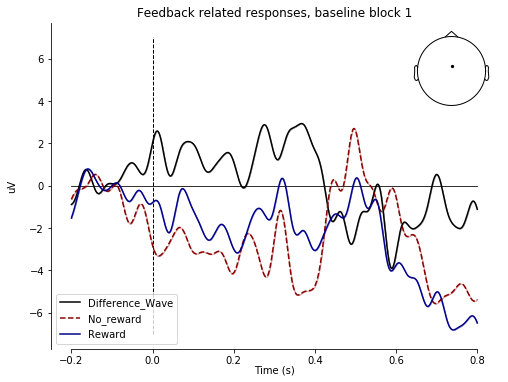

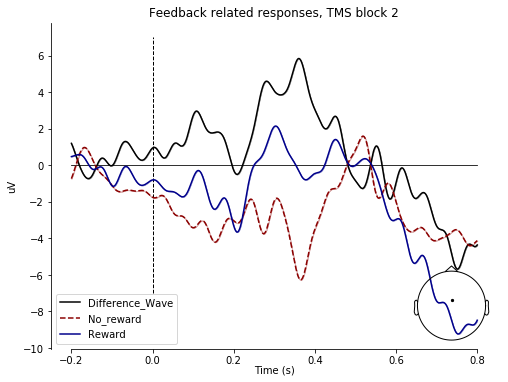

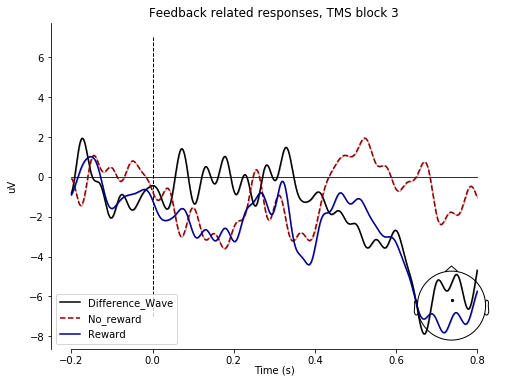

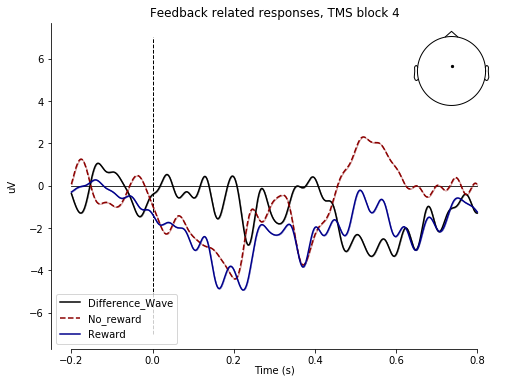

In [174]:
colors = dict(Reward = 'darkblue', No_reward = 'darkred', 
              Difference_Wave = 'black')

base_dict = {'Reward': reward_base, 'No_reward': noreward_base, 
               'Difference_Wave': difference_feedback_base}
tms_dict = {'Reward': reward_tms, 'No_reward': noreward_tms, 
               'Difference_Wave': difference_feedback_tms}
tms_dict2 = {'Reward': reward_tms2, 'No_reward': noreward_tms2, 
               'Difference_Wave': difference_feedback_tms2}
tms_dict3 = {'Reward': reward_tms3, 'No_reward': noreward_tms3, 
               'Difference_Wave': difference_feedback_tms3}

linestyles = dict(Reward = '-', No_reward = '--', 
                  Difference_Wave = '-')

ylim = dict(eeg=[-7,7])

mne.viz.plot_compare_evokeds(base_dict, picks=[7], 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses, baseline block 1',
                             show_sensors=True);

mne.viz.plot_compare_evokeds(tms_dict, picks=[7], 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses, TMS block 2',
                             show_sensors=True);

mne.viz.plot_compare_evokeds(tms_dict2, picks=[7], 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses, TMS block 3',
                             show_sensors=True);

mne.viz.plot_compare_evokeds(tms_dict3, picks=[7], 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses, TMS block 4',
                             show_sensors=True);